## New main.py as of 241217. 

### Here I want to avoid doing BLAST against the commercial proteins as that is primarily used for finding sequentially different proteins. 

### I also do not want to filter for unique tseq as it they may be relevant for alignments to different query proteins. This will be checked manually


### Step 1

I don't want to find identical proteins, so the FoldSeek results (tseq) will be filtered for sequentially exactly the same sequences as present in the BPPRC and Commercial protein databases (both with protoxin (original fasta files) and without protoxin (from PDBs)). 

### Step 2

I want to maximise tha chance of finding new structures with nematocidial activity. As such, I will only proceed with the target sequences for the query proteins known to have nematocidial effect.

### Step 3

Once I have filtered sequentially identical proteins to BPPRC and commercial proteins, I will upload the results to AirTable to manually go through strucutres to find structurally similar proteins. 

### Step 4

BLAST the structurally similar targets agianst NCBI, Pataa and AllergensOnline

### Step 5 

Remove the targets with identical matches from the BLAST

In [1]:
import pandas as pd
import numpy as np
import Bio as bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.PDB import PDBParser
from Bio.Data import IUPACData
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import plotly.express as px
import re
import os

### Start with processing the raw FoldSeek data, including Q- & T-Tm scores and keeping only unique tseqs

In [10]:
# Load the raw foldseek data
raw_df = pd.read_csv('/Volumes/behavgenom$/John/data_exp_info/BT/FoldSeek/commercial_proteins/2_FoldSeekRaw/FirstFoldSeekdf_mod.csv')



In [11]:
print(len(raw_df))

76087


### Filtering for the q & t tmscore was originally applied. But we also want to see what the structures look like when they have no filters applied for the strucutres. The only proteins of interest are the nematocidial commercial proteins, so I will filter based on that, followed by filtering the BPPRC, the PDB sequence of the commercial proteins and the full-length commercial protoxins that have not been truncated. 

In [12]:
print(raw_df[raw_df['query'] == 'AF3-cry1Da_7-241209'].head)
print(raw_df[raw_df['query'] == 'AF3-cry1F-241206'].head)
print(raw_df[raw_df['query'] == 'AF3-cry14Ab-1.b-241209'].head)

proteins_of_interest = ['AF3-cry1Da_7-241209', 'AF3-cry1F-241206', 'AF3-cry14Ab-1.b-241209']

# filter the data by the query names of interest (nematocidal commercial proteins)
filtered_df = raw_df[raw_df['query'].str.contains('AF3-cry1Da_7-241209|AF3-cry1F-241206|AF3-cry14Ab-1.b-241209')]
print(filtered_df.head)

# check if the filtered data contains any other proteins
if (~filtered_df['query'].isin(proteins_of_interest)).any():
    print('no')
else:
    print('Only the proteins of interest are present in the filtered data!')



<bound method NDFrame.head of                      query                     target  fident  alnlen  \
55976  AF3-cry1Da_7-241209  AF-A0A0B4KE67-F1-model_v4   0.991     613   
55977  AF3-cry1Da_7-241209  AF-A0A482G4T8-F1-model_v4   0.996     613   
55978  AF3-cry1Da_7-241209      AF-D0EI56-F1-model_v4   0.995     613   
55979  AF3-cry1Da_7-241209      AF-P0A375-F1-model_v4   1.000     613   
55980  AF3-cry1Da_7-241209      AF-Q6YNB8-F1-model_v4   0.995     613   
...                    ...                        ...     ...     ...   
57794  AF3-cry1Da_7-241209      AF-Q8LNU0-F1-model_v4   0.085     282   
57795  AF3-cry1Da_7-241209      AF-D3ZIT4-F1-model_v4   0.108     305   
57796  AF3-cry1Da_7-241209      AF-Q9LFM6-F1-model_v4   0.098     364   
57797  AF3-cry1Da_7-241209      AF-C6T8U3-F1-model_v4   0.116     215   
57798  AF3-cry1Da_7-241209      AF-Q8LIJ9-F1-model_v4   0.117     350   

       mismatch  gapopen  qstart  qend  tstart  tend  ...  \
55976         6        0       1

Filter these for the BPPRC, the truncated and untruncated commercial proteins

In [17]:
# Load the BPPRC database txt file and transform it to a dataframe
# BPPRC database
bpprc_path =  '/Volumes/jb3623$-1/Projects/bt-like_toxins/BPPRC_db/all_app_cry_cyt_gpp_mcf_mpf_mpp_mtx_pra_prb_spp_tpp_txp_vip_vpa_vpb_xpp_fasta_sequences.txt'
bpprc_db = SeqIO.to_dict(SeqIO.parse(bpprc_path, 'fasta'))


# Extract data and create a dataframe
data = {
    "id": [],
    "description": [],
    "sequence": []
}

for record in bpprc_db.values():
    data["id"].append(record.id)
    data["description"].append(record.description)
    data["sequence"].append(str(record.seq))

bpprc_df = pd.DataFrame(data)

bpprc_df


# Load the truncated commercial proteins:
truncated_commercial_proteins = pd.read_csv('/Volumes/behavgenom$/John/data_exp_info/BT/FoldSeek/commercial_proteins/1_commerical_proteins_processing/all_commercial_proteins/fasta_sequences/from_all_commercial_pdbs/compiled_sequences.csv')

# Load the untruncated commercial proteins:
original_commercial_proteins_path = '/Volumes/behavgenom$/John/data_exp_info/BT/FoldSeek/commercial_proteins/1_commerical_proteins_processing/all_commercial_proteins/fasta_sequences/commercial_proteins_with_protoxin.fasta'
original_commercial_proteins = SeqIO.to_dict(SeqIO.parse(original_commercial_proteins_path, 'fasta'))

# Extract data and create a dataframe
data = {
    "id": [],
    "description": [],
    "sequence": []
}

for record in original_commercial_proteins.values():
    data["id"].append(record.id)
    data["description"].append(record.description)
    data["sequence"].append(str(record.seq))

original_commercial_proteins_df = pd.DataFrame(data)

original_commercial_proteins_df

,id,description,sequence
0,cry34Ab1,cry34Ab1,MSAREVHIDVNNKTGHTLQLEDKTKLDGGRWRTSPTNVANDQIKTF...
1,cry35Ab1,cry35Ab1,MLDTNKVYEISNHANGLYAATYLSLDDSGVSLMNKNDDDIDDYNLK...
2,cry3A,cry3A,MIRKGGRKMNPNNRSEHDTIKTTENNEVPTNHVQYPLAETPNPTLE...
3,cry3Bb1,cry3Bb1,MNPNNRSEHDTIKVTPNSELQTNHNQYPLADNPNSTLEELNYKEFL...
4,ipd072Aa,ipd072Aa,MGITVTNNSSNPIEVAINHWGSDGDTSFFSVGNGKQETWDRSDSRG...
5,ipd079Ea,ipd079Ea,MEPNKGGAPAMKNVAKPSTKRLIPSSIAASSQTSANALTEPLPGSD...
6,mcry3A,mcry3A,MTAKDIATEESKIRAYAQWMEITIFVVNSNFKVEGAYLRWGKFHVP...
7,mCry51Aa2,mCry51Aa2,MAILDLKSLVLNAINYWGPKNNNGIQGGDFGYPISEKQIDTSIITS...
8,cry1A,cry1A,MGGNFTIPMDLMTTIDSTEHYSGYPILTWISSPDNSYSGRFMSWYF...
9,cry1A.105,cry1A.105,MDNNPNINECIPYNCLSNPEVEVLGGERIETGYTPIDISLSLTQFL...


In [18]:
# check the loaded data
print(original_commercial_proteins_df.iloc[0])
print(truncated_commercial_proteins.iloc[0])
print(bpprc_df.iloc[0])

id                                                      cry34Ab1
description                                             cry34Ab1
sequence       MSAREVHIDVNNKTGHTLQLEDKTKLDGGRWRTSPTNVANDQIKTF...
Name: 0, dtype: object
name                                    AF3-cry1Da_7-241209_A
sequence    MEENNQNQCIPYNCLSNPEEVLLDGERISTGNSSIDISLSLVQFLV...
length                                                    613
Name: 0, dtype: object
id                                                       App1Aa1
description                                              App1Aa1
sequence       MEKYMLLAQFPAEKTLNETDIPSATLQLLTGKQAGVARPGGIFTKE...
Name: 0, dtype: object


Filter the FoldSeek data with only nematocidal query proteins for the BPPRC, and the commercial truncated and untruncated 

In [19]:
# Combine all sequences from the three dataframes into a single set for fast lookup
all_sequences = set(original_commercial_proteins_df['sequence']).union(
    set(truncated_commercial_proteins['sequence']),
    set(bpprc_df['sequence'])
)

# Add the 'is_duplicate' column to filtered_df
filtered_df['is_duplicate'] = filtered_df['tseq'].apply(lambda x: x in all_sequences)

# Print the updated filtered_df
print(f"Number of sequences in nematocidial foldseek filtered data: {len(filtered_df)}")
print(f"Number of sequences found in BPPRC, truncated and untruncated commercial sequences:", filtered_df['is_duplicate'].value_counts())

# Filter out the duplicates
filtered_df = filtered_df[~filtered_df['is_duplicate']]
print(f"Number of sequences in nematocidial foldseek filtered data after removing duplicates: {len(filtered_df)}")

Number of sequences in nematocidial foldseek filtered data: 6660
Number of sequences found in BPPRC, truncated and untruncated commercial sequences: False    5638
True     1022
Name: is_duplicate, dtype: int64
Number of sequences in nematocidial foldseek filtered data after removing duplicates: 5638


/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_30173/3892106031.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['is_duplicate'] = filtered_df['tseq'].apply(lambda x: x in all_sequences)


## Now we have a dataset that is filtered for only nematocidal query proteins, that is not found in BPPRC, truncated commercail proteins or untruncated commercail proteins

In [44]:
# save filtered_df
filtered_df.to_csv('/Volumes/behavgenom$-1/John/data_exp_info/BT/FoldSeek/commercial_proteins/3_FoldSeekRaw_processing/no_structural_filter/filtered_foldseek_data.csv', index=False)


In [18]:
'''print(f"Number of rows in raw foldseek data: {len(raw_df)}")

# Set the lower threshold for structure similarity scores for both the query and target proteins
qtmscore = 0.4
ttmscore = 0.4

# Process the raw FoldSeek data by making a new dataframe that have an additional column that states TRUE or FALSE if the query and target proteins have a structure similarity score above the thresholds
processed_df = raw_df.copy()
processed_df['QueryTmScore'] = processed_df['qtmscore'] > qtmscore
processed_df['TargetTmScore'] = processed_df['ttmscore'] > ttmscore

tm_filtered = processed_df[(processed_df['QueryTmScore'] == True) & (processed_df['TargetTmScore'] == True)]
num_tm_filtered = len(tm_filtered)
print(f"Number of proteins that have a q- & ttmscore above 0.4:", num_tm_filtered)

# Count the number of duplicate strings in the 'tseq' column
num_duplicates = tm_filtered['tseq'].duplicated().sum()
print(f"Number of duplicate strings in 'tseq': {num_duplicates}")

'''



Number of rows in raw foldseek data: 76087
Number of proteins that have a q- & ttmscore above 0.4: 20056
Number of duplicate strings in 'tseq': 14749


In [20]:
# Load the PDBs of the commercial proteins used for FoldSeek and transform the names and sequeces to a dataframe 

commercial_pdb_path = '/Volumes/behavgenom$/John/data_exp_info/BT/FoldSeek/commercial_proteins/1_commerical_proteins_processing/all_commercial_proteins/all_commercial_pdbs'
csv_save_path = '/Volumes/behavgenom$/John/data_exp_info/BT/FoldSeek/commercial_proteins/1_commerical_proteins_processing/all_commercial_proteins/fasta_sequences/from_all_commercial_pdbs/compiled_sequences.csv'

os.makedirs(os.path.dirname(csv_save_path), exist_ok=True)

# Function to extract sequences from a PDB file
def extract_sequences_from_pdb(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(os.path.basename(pdb_file), pdb_file)
    sequences = []
    
    for model in structure:
        for chain in model:
            chain_id = chain.id
            seq = []
            for residue in chain:
                if residue.id[0] == ' ':
                    three_letter_code = residue.resname
                    one_letter_code = IUPACData.protein_letters_3to1.get(three_letter_code.capitalize(), 'X')
                    if one_letter_code == 'X':
                        print(f"Unknown residue: {three_letter_code} in {pdb_file}")
                    seq.append(one_letter_code)
            seq_str = ''.join(seq)
            seq_record = SeqRecord(Seq(seq_str), id=f"{os.path.basename(pdb_file).split('.')[0]}_{chain_id}", description="")
            sequences.append(seq_record)
    
    return sequences

# Initialize data dictionary
data = {
    "name": [],
    "sequence": [],
    "length": []
}

# Iterate over all PDB files in the directory
for pdb_file in os.listdir(commercial_pdb_path):
    if pdb_file.endswith('.pdb'):
        pdb_file_path = os.path.join(commercial_pdb_path, pdb_file)
        sequences = extract_sequences_from_pdb(pdb_file_path)
        
        for seq_record in sequences:
            data["name"].append(seq_record.id)
            data["sequence"].append(str(seq_record.seq))
            data["length"].append(len(seq_record.seq))

# Create dataframe
commercial_df = pd.DataFrame(data)
print(f"Number of unique sequences: {len(commercial_df)}")





Number of unique sequences: 33


In [ ]:
# Save commercial dataframe to CSV
commercial_df.to_csv(csv_save_path, index=False)

print(f"CSV file has been created at {csv_save_path}")

In [27]:

#Rename the column 'sequence' in bpprc_df to 'bpprc_seq'
bpprc_df = bpprc_df.rename(columns={'sequence': 'bpprc_seq'})
print(f"Number of sequences in BPPRC database: {len(bpprc_df)}")

#Rename the column 'sequence' in commercial_df to 'commercial_seq'
commercial_df = commercial_df.rename(columns={'sequence': 'commercial_seq'})
print(f"Number of sequences in commercial proteins: {len(commercial_df)}")

# Check only unique sequences
bpprc_unique_df = bpprc_df.drop_duplicates(subset='bpprc_seq')
commercial_unique_df = commercial_df.drop_duplicates(subset='commercial_seq')

print(f"Number of unique sequences in BPPRC database: {len(bpprc_unique_df)}")
print(f"Number of unique sequences in commercial proteins: {len(commercial_unique_df)}")


Number of sequences in BPPRC database: 1151
Number of sequences in commercial proteins: 33
Number of unique sequences in BPPRC database: 963
Number of unique sequences in commercial proteins: 31


In [22]:
fs_tseq_df = tm_filtered.copy()
fs_tseq_df['tseq']

0        MSAREVHIDVNNKTGHTLQLEDKTKLDGGRWRTSPTNVANDQIKTF...
1        MSAREVHIDVNNKTGHTLQLEDKTKLDGGRWRTSPTNVANDQIKTF...
2        MSAREVHINVNNKTGHTLQLEDKTKLDGGRWRTSPTNVANDQIKTF...
3        MSAREVHIDVNNKTGHTLQLEDKTKLDGGRWRTSPTNVANDQIKTF...
4        MSAREVHIEINNKTRHTLQLEDKTKLSGGRWRTSPTNVARDTIKTF...
                               ...                        
73908    DYFNGIYGFATGIKDIMGMIFKTDTGGNLTLDEILKNQNLLNDISG...
73909    DYFNGIYGFATGIKDIMGMIFKTDTGNLTLDEILKNQNLLNDISGK...
73910    DYFNGIYGFATGIKDIMGMIFKTDTGGSNLTLDEILKNQNLLNDIS...
73911    QNHVLSLQIEFLSKQLQEISDKLDIINLNVLINSTLTEITPAYQRI...
73912    EQNQMLNHVNAQLNAINSTLNIYLPKITSMLNEVMKQNHVLSLQIE...
Name: tseq, Length: 20056, dtype: object

Check if there are sequences in the fs_tseq_df that are exactly the same in the **commercial_df** and in the **bpprc_df**

In [28]:
print(f"Number of unique sequences in fs_tseq_df: {len(fs_tseq_df)}")

fs_tseq_df['is_in_commerial_df'] = fs_tseq_df['tseq'].isin(commercial_unique_df['commercial_seq'])
sequences_in_commercial_df = fs_tseq_df[fs_tseq_df['is_in_commerial_df']]

print("Sequences in fs_tseq_df that are found in commercial_df:", len(sequences_in_commercial_df))


Number of unique sequences in fs_tseq_df: 20056
Sequences in fs_tseq_df that are found in commercial_df: 175


In [29]:
fs_tseq_df['is_in_bpprc_df'] = fs_tseq_df['tseq'].isin(bpprc_unique_df['bpprc_seq'])
sequences_in_bpprc_df = fs_tseq_df[fs_tseq_df['is_in_bpprc_df']]

print("Sequences in fs_tseq_df that are found in commercial_df:", len(sequences_in_bpprc_df))

Sequences in fs_tseq_df that are found in commercial_df: 7071


### Let's remove those duplicates

In [31]:
duplicates_to_remove = fs_tseq_df[(fs_tseq_df['is_in_commerial_df'] == True) | (fs_tseq_df['is_in_bpprc_df'] == True)]
print("Number of duplicates to remove:", len(duplicates_to_remove))

Number of duplicates to remove: 7135


In [34]:
fs_tseq_commercial_bpprc_filtered = fs_tseq_df[(fs_tseq_df['is_in_commerial_df'] == False) & (fs_tseq_df['is_in_bpprc_df'] == False)]
print("Number of sequences that are not found in commercial_df or bpprc_df:", len(fs_tseq_commercial_bpprc_filtered))

Number of sequences that are not found in commercial_df or bpprc_df: 12921


In [35]:
fs_tseq_unique_test = fs_tseq_commercial_bpprc_filtered.drop_duplicates(subset='tseq')
print("Number of unique sequences in fs_tseq_unique_test:", len(fs_tseq_unique_test))

Number of unique sequences in fs_tseq_unique_test: 4805


### I am left with 12921 target sequences from the FoldSeek search that are not found in the BPPRC database and is not one of the Commercial proteins

In [14]:
fs_tseq_commercial_bpprc_filtered.columns

Index(['query', 'target', 'fident', 'alnlen', 'mismatch', 'gapopen', 'qstart',
       'qend', 'tstart', 'tend', 'tseq', 'evalue', 'bits', 'cigar',
       'alntmscore', 'qtmscore', 'ttmscore', 'rmsd', 'u', 't', 'lddt',
       'lddtfull', 'prob', 'taxid', 'taxname', 'taxlineage', 'database',
       'QueryProteinLength', 'TargetProteinLength', 'QueryTmScore',
       'TargetTmScore', 'is_in_commerial_df', 'is_in_bpprc_df'],
      dtype='object')

In [36]:
# Define the save path
save_path = '/Volumes/behavgenom$/John/data_exp_info/BT/FoldSeek/commercial_proteins/3_FoldSeekRaw_processing/fs_targets_not_in_bpprc_or_commercial'
os.makedirs(save_path, exist_ok=True)

fs_tseq_commercial_bpprc_filtered.to_csv(os.path.join(save_path, 'fs_targets_not_in_bpprc_or_commercial.csv'), index=False)

## After manual checking of structural similarity of target to query, 297 target structures were found. These were found with the following filters in AirTable: 

1. Target sequence length >450

I have gone through a total of more than 2000 structures, including all of Cry1Da_7 and Cry1F, and 646 of Cry14Ab-1.b. There are 587 left to check of Cry14Ab-1.b that are all of a q/t TM-score of below 0.2. The vast majority with Tm-scores below 0.4 look very different in structure to query. Out of the 960 counted with Tm scores below 0.2 across all three queries, there are only 5 predicted structures that look like the query. As such, the risk of missing a structure that looks similar to query with such low q/t Tm-score is low. 


In [25]:
# Read in the AirTable data
airtable_df = pd.read_csv('/Volumes/behavgenom$-1/John/data_exp_info/BT/FoldSeek/commercial_proteins/3_FoldSeekRaw_processing/AirTable/241229_FoldSeek_results_structural_check.csv')


In [ ]:
# Create a multi-fasta file for BLAST searches out of airtable_df 'target' as name and airtable_df 'tseq' as the amino acid sequence
with open('/Volumes/behavgenom$/John/data_exp_info/BT/FoldSeek/commercial_proteins/3_FoldSeekRaw_processing/AirTable/airtable_targets.fasta', 'w') as f:
    for index, row in airtable_df.iterrows():
        f.write(f">{row['target']}\n{row['tseq']}\n")

## Time to do BLAST searches against the following databases:

1. Allergens

2. Pataa (patented - check if match is an active patent or not)

3. NCBI 

In [4]:
## Read in the BLAST results

# Allergens
allergens_df = pd.read_csv('/Volumes/behavgenom$-1/John/data_exp_info/BT/FoldSeek/commercial_proteins/4_BLAST/3_Allergens_BLAST_airtable/blast_allergen_results_Allergen.tsv', delimiter='\t')

# Pataa
pataa_df = pd.read_csv('/Volumes/behavgenom$-1/John/data_exp_info/BT/FoldSeek/commercial_proteins/4_BLAST/2_Pataa_BLAST_airtable/blast_pataa_results_Pataa.tsv', delimiter='\t')

# NCBI
ncbi_df = pd.read_csv('/Volumes/behavgenom$-1/John/data_exp_info/BT/FoldSeek/commercial_proteins/4_BLAST/1_NCBI_BLAST_airtable/blast_ncbi_results_NCBI.tsv', delimiter='\t')



### Look at the results for BLAST search against the AllergensOnline database first

Codex Alimentarius Commission (2003) suggests that matches of at least 35% identity over 80 amino acid segments may indicate cross-reactivity.

**Thus, the first criteria for allergenic proteins is that the percent identity should be >= 35% for segement matches that are 80 amino acids or longer.**

**If scientifically justified, the second criteria for allergenic proteins is that there are at least 8 contiguous amino acids that are identical in sequence between query and target.**



In [5]:
## First check the number of hits for the BLAST search against the Allergen database
print("Number of hits in the allergen database:", len(allergens_df))

## Check the number of unique queries in the allergen BLAST results
print("Number of unique queries in the allergen database:", len(allergens_df['qseqid'].unique()))

Number of hits in the allergen database: 148
Number of unique queries in the allergen database: 100


Given that there are only BLAST results for 100 out of the 297 queries, there are 197 with very low similarity to any of the targets in the AllergenOnline database. The missing ones are thus 'safe' to proceed with. 

In [6]:
## Check the first criteria for the allergen BLAST results

# new column for percent identity >= 35% for segement matches that are 80 amino acids or longer 
allergens_df['pident_length_above_threshold'] = (allergens_df['length'] >= 80) & (allergens_df['pident'] >= 35)
print(f"Number of rows with percent identity >= 35% for segement matches that are 80 amino acids or longer:", allergens_df['pident_length_above_threshold'].sum())

# One row that passes this criteria is the following:
print(allergens_df[allergens_df['pident_length_above_threshold'] == True].head(1))
allergen_investigate = allergens_df[allergens_df['pident_length_above_threshold'] == True].head(1)



Number of rows with percent identity >= 35% for segement matches that are 80 amino acids or longer: 1
    Unnamed: 0                     qseqid           sseqid  pident  length  \
24          24  AF-A0A854Z344-F1-model_v4  emb|CAB02213.1|  35.366      82   

    mismatch  gapopen  qstart  qend  sstart  ...  sscinames  scomnames  \
24        45        4     905   984      82  ...        NaN        NaN   

    sblastnames                                 ss.kingdoms  \
24          NaN  pollen allergen Car b 1 [Carpinus betulus]   

                                        stitle  salltitles  sstrand  \
24  pollen allergen Car b 1 [Carpinus betulus]         NaN      NaN   

                                        QuerySequence  \
24  MNQQHNNEYEIMSTGDMGYQPRYPFSNAPGAELQQMHYKDWMDMCA...   

                                         FullSequence  \
24  MGVFNYEAETPSVIPAARLFKSYVLDFDKLIPKVAPQAISSVENVG...   

   pident_length_above_threshold  
24                          True  

[1 rows x 44 columns]

One query to allergen target passess the first criteria with having a pident above 35% with segement match that is over 80 amino acids long (AF-A0A854Z344-F1-model_v4). 

The target starts at 905 and ends at 984 of the query (protoxin segment) and is a pollen allergen (Carpinus betulus). 



_The alignment is poor. It spans 82 amino acids with only 27.3 bitscore, and 45 mismatches, 29 aligned amino acids, 4 gapopen, and 8 gaps in total. I do not think this should be discarded._

_***Should the nature of this match be investigated further to decide if included or not?***_

In [7]:
## Check the second criteria for the allergen BLAST results

# new column for rows with at least 8 contiguous amino acids 
allergens_df['btop_min8'] = allergens_df['btop'].str.contains(r'\b[8-9]\b|\b[1-9][0-9]+\b')
print(f"Number of rows with at least 8 contiguous amino acids:", allergens_df['btop_min8'].sum())

Number of rows with at least 8 contiguous amino acids: 0


No allergens have a contiguous amino acid sequence match with a query. 

### Now let's look at the results from BLAST against the Patent database (Pataa)

In [8]:
## First check the number of hits for the BLAST search against the patent database
print("Number of hits in the patent database:", len(pataa_df))

## Check the number of unique queries in the patent BLAST results
print("Number of unique queries in the patent database:", len(pataa_df['qseqid'].unique()))



Number of hits in the patent database: 134637
Number of unique queries in the patent database: 295


### Given that 297 query sequences were blasted against pataa, and there are 295 unique queries in the pataa blast results, there are TWO queries which are too different from anything in the pataa database to give a result.

In [9]:
print(pataa_df['length'].dtype)
print(pataa_df['qlen'].dtype)
print(pataa_df['slen'].dtype)

pataa_df['qlen'] = pataa_df['qlen'].astype(int)

int64
int64
int64


In [10]:
# Check how many unique qseqids have all of the following conditions in the pataa_df for a perfect match:
## 1. qlen = length
## 2. slen = length
## 3. qlen = slen
## 4. mismatch = 0
## 5. gapopen = 0
## 6. gaps = 0

# Step 1: Filter the DataFrame based on the conditions
perfect_pataa_match = pataa_df[(pataa_df['qlen'] == pataa_df['length']) & 
                                (pataa_df['slen'] == pataa_df['length']) & 
                                (pataa_df['qlen'] == pataa_df['slen']) &
                                (pataa_df['mismatch'] == 0) &
                                (pataa_df['gapopen'] == 0) &
                                (pataa_df['gaps'] == 0)]

# Step 2: Count the unique qseqids
unique_qseqids_perfect_pataa_match_count = perfect_pataa_match['qseqid'].nunique()

# Print the count of unique qseqids
print(unique_qseqids_perfect_pataa_match_count)


## OR just check which sequences have a perfect match in 'QuerySequence' and 'FullSequence'
perfect_match_two = pataa_df[(pataa_df['QuerySequence'] == pataa_df['FullSequence'])]
print(len(perfect_match_two))


24
24


#### Here I have created a function to calculate a 'Similarity Score'. This is because: 

1. The 'pident' does not take into account if the identity is to the whole of both the query and the target protein. 

2. The columns 'QuerySequence' and 'FullSequence' (full target sequence) will select for those wuth exact matches. We probably want slightly more different strucutres to avoid patented.

3. To find target proteins that are both exactly the same and highly similar, a combination of several parameters have to be taken into account. 

**To be exactly the same or very similar, these are the parameters to consider:**

1. ‘Positive’: positions in the alignment where the amino acids in the query and subject sequences are not identical but are biochemically similar. A perfect match has the same ‘positive’ number as qlen, slen, and length (alignment). 

2. Dividing by ‘slen’ ensures that the match is relative to the length of the target sequence. Whether the query sequence is with or without a protoxin does not matter as the match needs to be a solid match to the patented protein. So, a strong match that has ‘Positive’ as the same or very similar length as the target proteins allows us to cover for queries that are either missing a protoxin or has a protoxin that the target doesn’t have. 



In [11]:
# Check the range of qlen 
print(pataa_df['qlen'].min())

lower_slen_limit = int(0.8 * pataa_df['qlen'].min())
print(lower_slen_limit)


566
452


In [12]:
print(f"Total number of rows from the Patented Proteins BLAST:", len(pataa_df))
print(f"Number of rows where the target length is shorter than 80% of the shortest query length:",len(pataa_df[pataa_df['slen'] < lower_slen_limit]))

pataa_filtered = pataa_df[pataa_df['slen'] >= lower_slen_limit]
print(f"Number of rows where the target length is longer than 80% of the shortest query length:", len(pataa_filtered))

Total number of rows from the Patented Proteins BLAST: 134637
Number of rows where the target length is shorter than 80% of the shortest query length: 1148
Number of rows where the target length is longer than 80% of the shortest query length: 133489


In [13]:
# Calculate the proportion using both qlen and slen
pataa_filtered['positive_prop_qlen'] = pataa_filtered['positive'] / pataa_filtered['qlen']
pataa_filtered['positive_prop_slen'] = pataa_filtered['positive'] / pataa_filtered['slen']

# Determine which proportion is closer to 1.0 for each row
pataa_filtered['positive_prop'] = pataa_filtered.apply(
    lambda row: row['positive_prop_qlen'] if abs(row['positive_prop_qlen'] - 1.0) < abs(row['positive_prop_slen'] - 1.0) else row['positive_prop_slen'],
    axis=1
)

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_14341/2040135276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pataa_filtered['positive_prop_qlen'] = pataa_filtered['positive'] / pataa_filtered['qlen']
/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_14341/2040135276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pataa_filtered['positive_prop_slen'] = pataa_filtered['positive'] / pataa_filtered['slen']
/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_14341/204013527

In [14]:
# Sort by 'positive_prop' and 'qseqid' to ensure consistent order
pataa_filtered = pataa_filtered.sort_values(['positive_prop', 'qseqid'], ascending=[False, True])

# Keep the qseqid for the highest scoring hit for each query on 'positive_prop'
pataa_filtered_unique_positive_prop = pataa_filtered.drop_duplicates('qseqid')

print(f"Number of rows with positive proportion below 0.8:", len(pataa_filtered_unique_positive_prop[pataa_filtered_unique_positive_prop['positive_prop'] < 0.8]))
below_08 = pataa_filtered_unique_positive_prop[pataa_filtered_unique_positive_prop['positive_prop'] < 0.8]

Number of rows with positive proportion below 0.8: 99


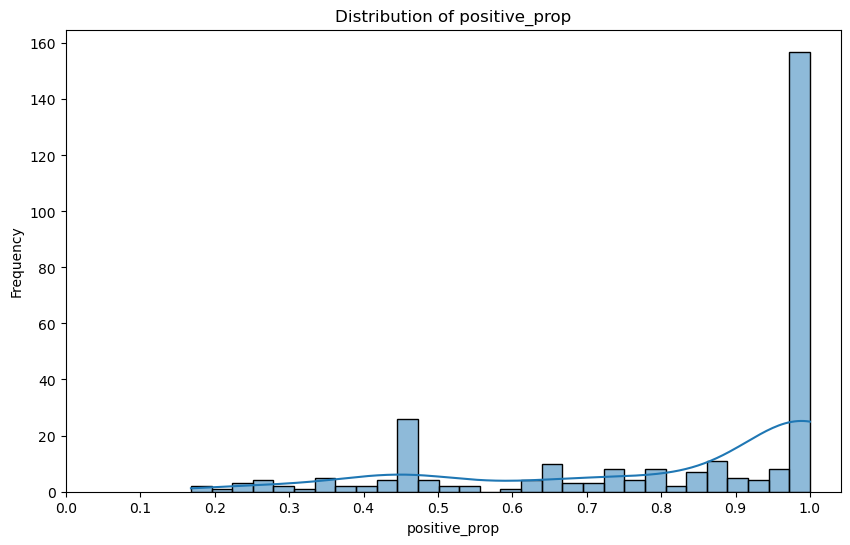

In [15]:
# make a histogram plot for the diversity of similarity scores
plt.figure(figsize=(10, 6))
sns.histplot(pataa_filtered_unique_positive_prop['positive_prop'], bins=30, kde=True) 
plt.title("Distribution of positive_prop")
plt.xlabel("positive_prop")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

### There are 24 queries that have exactly the same sequence in query and target. These should probably be removed, but worth investigating if these are active patents. 

The rows with exactly the same query and target sequence are the only ones with a similarity score of 1, proving this formula works to find the rows with the same query and target sequence. 

The benefit of this formula is that we can see how many target sequences are also highly similar, allowing us to make an informative decision of which sequences to move forward with and which ones to discard as being too similar to the patented proteins. 

In [16]:
# Filter the data not to proceed with to a new dataframe called 'not_keep_pataa' 
not_keep_pataa = pataa_filtered_unique_positive_prop[(pataa_filtered_unique_positive_prop['positive_prop'] >= 0.8)]
len(not_keep_pataa)

196

In [188]:
# Save the 'not_keep_pataa' dataframe to a csv file
not_keep_pataa.to_csv('/Volumes/behavgenom$/John/data_exp_info/BT/FoldSeek/commercial_proteins/4_BLAST/2_Pataa_BLAST_airtable/not_keep_pataa.csv', index=False)

# Save the pataa_df 'below_08' to move forward with to a csv file
below_08.to_csv('/Volumes/behavgenom$/John/data_exp_info/BT/FoldSeek/commercial_proteins/4_BLAST/2_Pataa_BLAST_airtable/below_08.csv', index=False)

### Some of the sequences with a similarity score above 80% have expired or undocumented patents. It would be useful to include them as well, but to do that I need to ensure that any targets with a positive proportion above 0.8 to the queries with the highest positive proportion score being above 80% do not have any active patents.

To do this, i will import a list with the queries having a target scoring above 80% in the positive proportion. I will then filter the pataa_filtered to only include these queries and their associated targets that together give a positive proportion above 0.8.

In [17]:
expired_patents = pd.read_csv('/Volumes/behavgenom$-1/John/data_exp_info/BT/FoldSeek/commercial_proteins/4_BLAST/2_Pataa_BLAST_airtable/expired_patents_above_08_unique.csv')

In [18]:
pataa_qseqid_patent_expired = pataa_filtered[pataa_filtered['qseqid'].isin(expired_patents['qseqid'])]

In [19]:
# Filter for equal to or above 0.8 positive proportion score
pataa_qseqid_patent_expired_08 = pataa_qseqid_patent_expired[pataa_qseqid_patent_expired['positive_prop'] >= 0.8]
print(len(pataa_qseqid_patent_expired_08))

4831


Save this as a csv and look through each target sequence per unique query until I find a patent that is 'active'. If no active patents are listed for a target, these can be moved forward with in my experiments. 

In [192]:
# Save the 'pataa_qseqid_patent_expired_08_filtered' dataframe to a csv file
pataa_qseqid_patent_expired_08.to_csv('/Volumes/behavgenom$/John/data_exp_info/BT/FoldSeek/commercial_proteins/4_BLAST/2_Pataa_BLAST_airtable/pataa_qseqid_patent_expired_08_new.csv', index=False)

### 14 unique queries did not have any active patents associated with any of the target sequences found to have a length longer than 80% of the shortest query and a positive proportion score above 0.8. 

These 14 sequences should not be reomved from the NCBI BLAST data as they are not patented. 

In [21]:
qseqids_true_expired_patents = pd.read_csv('/Volumes/behavgenom$-1/John/data_exp_info/BT/FoldSeek/commercial_proteins/4_BLAST/2_Pataa_BLAST_airtable/true_expired_patents.csv')

In [22]:
# Filter the 'not_keep_pataa' dataframe for qseqids that are in 'qseqids_true_expired_patents'
true_expired_patents_from_not_keep_pataa = not_keep_pataa[not_keep_pataa['qseqid'].isin(qseqids_true_expired_patents['qseqid'])]
print(len(true_expired_patents_from_not_keep_pataa))

## Create a new dataframe with the 'true_not_keep_pataa' to remove only the qseqids that have a positive proportion score above 0.8 and have an active patent
print(len(not_keep_pataa))
true_not_keep_pataa = not_keep_pataa[~not_keep_pataa['qseqid'].isin(qseqids_true_expired_patents['qseqid'])]
print(len(true_not_keep_pataa))

14
196
182


In [26]:
# Copy the 'below_08' datafarme into a new dataframe called 'pataa_cleared_df' and add these 14 proteins to this dataframe
pataa_cleared_df = below_08.copy()
print(len(pataa_cleared_df))
pataa_cleared_df = pataa_cleared_df.append(true_expired_patents_from_not_keep_pataa)
print(len(pataa_cleared_df))

# There were two proteins from the 'airtable_df' that did not give any result in the BLAST agianst Pataa, so they should be added to the 'pataa_cleared_df'
no_pataa_result = airtable_df[~airtable_df['target'].isin(pataa_df['qseqid'])]
print(len(no_pataa_result))

pataa_cleared_df = pataa_cleared_df.append(no_pataa_result)
print(f"Number of rows of the final pataa_cleared_df:", len(pataa_cleared_df))

99
113
2
Number of rows of the final pataa_cleared_df: 115


/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_14341/3413269955.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pataa_cleared_df = pataa_cleared_df.append(true_expired_patents_from_not_keep_pataa)
/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_14341/3413269955.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pataa_cleared_df = pataa_cleared_df.append(no_pataa_result)


#### Export the pataa_cleared_df to a csv

In [227]:
# Save the 'pataa_cleared_df' to a csv file
pataa_cleared_df.to_csv('/Volumes/behavgenom$/John/data_exp_info/BT/FoldSeek/commercial_proteins/5_final_check/pataa_cleared_df.csv', index=False)

## Let's look into NCBI BLAST results

In [28]:
ncbi_df = pd.read_csv('/Volumes/behavgenom$-1/John/data_exp_info/BT/FoldSeek/commercial_proteins/4_BLAST/1_NCBI_BLAST_airtable/blast_ncbi_results_NCBI.tsv', delimiter='\t')


In [29]:
print("Number of unique queries in the NCBI database:", len(ncbi_df['qseqid'].unique()))

Number of unique queries in the NCBI database: 297


## Let's check where the FoldSeek query sequences that I have selected to move forward with are found in a NCBI BLAST search on the original commercial cry nematocidal proteins that the data is based on

In [30]:
nematocidal_ncbi_df = pd.read_csv('/Volumes/behavgenom$-1/John/data_exp_info/BT/FoldSeek/commercial_proteins/4_BLAST/4_NCBI_BLAST_original_nematocidial/from_blast/ncbi_blast_results_NCBI.tsv', delimiter='\t')

In [31]:
# Get a list of the unique queries in the nematocidal_ncbi_df
nematocidial_query_unique = nematocidal_ncbi_df['qseqid'].unique()
print(f"unique queries in nematocidal_ncbi_df:", nematocidial_query_unique)


unique queries in nematocidal_ncbi_df: ['AF3-cry1Da_7-241209' 'AF3-cry1F-241206' 'AF3-cry14Ab-1']


In [32]:
# It is the FoldSeek results that I moved forward with to do the BLAST searches. These have become 'queries' now. 
# I have done a BLAST search against the NCBI database with the original nematocidial FoldSeek queries - these will not have any matches. 
# What I want to check is if the the 'queries' that I have moved forward with can be found in the results from the BLAST search against the original nematocidial FoldSeek queries, and thier position in the 
## BLAST search.

# I need: 
## 1) nematocidal data to be grouped by queries (3 groups)
## 2) The queries that I have moved forward with to be checked against the grouped data
## 3) The 'sseqid' / 'FullSequence' for the nematocidial data 
## 4) The position of the 'queries' that I have moved forward with in the grouped data


## This code checks for overlap and positions in the 'pataa_cleared_df' dataframe ##


# Step 1: Sort nematocidal_ncbi_df by 'bitscore' in descending order
nematocidal_ncbi_df_sorted = nematocidal_ncbi_df.sort_values(by='bitscore', ascending=False)

# Step 2: Create a list to store the positions
positions = []

# Step 3: Group the sorted DataFrame by 'qseqid'
grouped = nematocidal_ncbi_df_sorted.groupby('qseqid')

# Step 4: Iterate through each 'qseqid' in 'pataa_cleared_df'
for index, row in pataa_cleared_df.iterrows():
    qseqid_pataa_cleared_df = row['qseqid']
    query_sequence = row['QuerySequence']
    
    # Check if the qseqid exists in the grouped DataFrame as sseqid
    found = False
    for name, group in grouped:
        if qseqid_pataa_cleared_df in group['sseqid'].values:
            position = group.index[group['sseqid'] == qseqid_pataa_cleared_df].tolist()
            positions.append({
                'qseqid_pataa_cleared_df': qseqid_pataa_cleared_df,
                'QuerySequence': query_sequence,
                'position': position[0] + 1,  # Adding 1 to make it 1-based index
                'sseqid_nematocidal': group.loc[position[0], 'sseqid'],
                'FullSequence': group.loc[position[0], 'FullSequence']
            })
            found = True
            break
        elif query_sequence in group['FullSequence'].values:
            position = group.index[group['FullSequence'] == query_sequence].tolist()
            positions.append({
                'qseqid_pataa_cleared_df': qseqid_pataa_cleared_df,
                'QuerySequence': query_sequence,
                'position': position[0] + 1,  # Adding 1 to make it 1-based index
                'sseqid_nematocidal': group.loc[position[0], 'sseqid'],
                'FullSequence': group.loc[position[0], 'FullSequence']
            })
            found = True
            break
    
    if not found:
        positions.append({
            'qseqid_pataa_cleared_df': qseqid_pataa_cleared_df,
            'QuerySequence': query_sequence,
            'position': None,
            'sseqid_nematocidal': None,
            'FullSequence': None
        })

# Convert the positions list to a DataFrame for better readability
positions_nematocidial_df_pataa_cleared = pd.DataFrame(positions)

# Print the positions DataFrame
#print(positions_nematocidial_df_below_08)

In [33]:
## Check the number of sequences found to be a match in positions_nematocidial_df_pataa_cleared
print(f"Number of sequences found to be a match in positions_nematocidial_df_below_08:", len(positions_nematocidial_df_pataa_cleared[positions_nematocidial_df_pataa_cleared['position'].notnull()]))

# Check the max and min position of the sequences found to be a match in positions_nematocidial_df_pataa_cleared
print(f"Min position of the sequences found to be a match in positions_nematocidial_df_pataa_cleared:", positions_nematocidial_df_pataa_cleared['position'].min())
print(f"Max position of the sequences found to be a match in positions_nematocidial_df_pataa_cleared:", positions_nematocidial_df_pataa_cleared['position'].max())


Number of sequences found to be a match in positions_nematocidial_df_below_08: 6
Min position of the sequences found to be a match in positions_nematocidial_df_pataa_cleared: 1077.0
Max position of the sequences found to be a match in positions_nematocidial_df_pataa_cleared: 1288.0


#### 6 sequences are found with position between 1077-1288 as sorted by bitscore. All rest are nan.

### Next is to check for the 'true_not_keep_pataa' data that have a positive proportion above 0.8 and an active patent

In [34]:
# It is the FoldSeek results that I moved forward with to do the BLAST searches. These have become 'queries' now. 
# I have done a BLAST search against the NCBI database with the original nematocidial FoldSeek queries - these will not have any matches. 
# What I want to check is if the the 'queries' that I have moved forward with can be found in the results from the BLAST search against the original nematocidial FoldSeek queries, and thier position in the 
## BLAST search.

# I need: 
## 1) nematocidal data to be grouped by queries (3 groups)
## 2) The queries that I have moved forward with to be checked against the grouped data
## 3) The 'sseqid' / 'FullSequence' for the nematocidial data 
## 4) The position of the 'queries' that I have moved forward with in the grouped data


## This code checks for overlap and positions in the 'true_not_keep_pataa' dataframe ##


# Step 1: Sort nematocidal_ncbi_df by 'bitscore' in descending order
nematocidal_ncbi_df_sorted = nematocidal_ncbi_df.sort_values(by='bitscore', ascending=False)

# Step 2: Create a list to store the positions
positions = []

# Step 3: Group the sorted DataFrame by 'qseqid'
grouped = nematocidal_ncbi_df_sorted.groupby('qseqid')

# Step 4: Iterate through each 'qseqid' in 'true_not_keep_pataa'
for index, row in true_not_keep_pataa.iterrows():
    qseqid_true_not_keep_pataa = row['qseqid']
    query_sequence = row['QuerySequence']
    
    # Check if the qseqid exists in the grouped DataFrame as sseqid
    found = False
    for name, group in grouped:
        if qseqid_true_not_keep_pataa in group['sseqid'].values:
            position = group.index[group['sseqid'] == qseqid_true_not_keep_pataa].tolist()
            positions.append({
                'qseqid_true_not_keep_pataa': qseqid_true_not_keep_pataa,
                'QuerySequence': query_sequence,
                'position': position[0] + 1,  # Adding 1 to make it 1-based index
                'sseqid_nematocidal': group.loc[position[0], 'sseqid'],
                'FullSequence': group.loc[position[0], 'FullSequence']
            })
            found = True
            break
        elif query_sequence in group['FullSequence'].values:
            position = group.index[group['FullSequence'] == query_sequence].tolist()
            positions.append({
                'qseqid_true_not_keep_pataa': qseqid_true_not_keep_pataa,
                'QuerySequence': query_sequence,
                'position': position[0] + 1,  # Adding 1 to make it 1-based index
                'sseqid_nematocidal': group.loc[position[0], 'sseqid'],
                'FullSequence': group.loc[position[0], 'FullSequence']
            })
            found = True
            break
    
    if not found:
        positions.append({
            'qseqid_true_not_keep_pataa': qseqid_true_not_keep_pataa,
            'QuerySequence': query_sequence,
            'position': None,
            'sseqid_nematocidal': None,
            'FullSequence': None
        })

# Convert the positions list to a DataFrame for better readability
positions_nematocidial_df_ture_not_keep_pataa = pd.DataFrame(positions)

# Print the positions DataFrame
#print(positions_nematocidial_df_not_keep_pataa)

In [35]:
## Check the number of sequences found to be a match in positions_nematocidial_df_not_keep_pataa
print("Number of sequences found to be a match in positions_nematocidial_df_not_keep_pataa:", len(positions_nematocidial_df_ture_not_keep_pataa[positions_nematocidial_df_ture_not_keep_pataa['position'].notnull()]))

## Check the max and minimum position of the sequences found to be a match in positions_nematocidial_df_not_keep_pataa
print("Min position of the sequences found to be a match in positions_nematocidial_df_not_keep_pataa:", positions_nematocidial_df_ture_not_keep_pataa['position'].min())
print("Max position of the sequences found to be a match in positions_nematocidial_df_not_keep_pataa:", positions_nematocidial_df_ture_not_keep_pataa['position'].max())


Number of sequences found to be a match in positions_nematocidial_df_not_keep_pataa: 38
Min position of the sequences found to be a match in positions_nematocidial_df_not_keep_pataa: 9.0
Max position of the sequences found to be a match in positions_nematocidial_df_not_keep_pataa: 1509.0


#### 36 sequences from the 'not_keep' dataframe (are too similar to the patented sequences) are found in the commercial cry NCBI blast 

In [36]:
print(len(ncbi_df))
# Filter away the rows with a qseqid found in 'true_not_keep_pataa' qseqid
ncbi_pataa_filtered = ncbi_df[~ncbi_df['qseqid'].isin(true_not_keep_pataa['qseqid'])]
print(len(ncbi_pataa_filtered))

152411
55212


In [37]:
unique_ncbi_pataa_filtered = ncbi_pataa_filtered.drop_duplicates(subset='qseqid')
print(len(unique_ncbi_pataa_filtered))

# Save the 'unique_ncbi_pataa_filtered' to a csv file
unique_ncbi_pataa_filtered.to_csv('/Volumes/behavgenom$/John/data_exp_info/BT/FoldSeek/commercial_proteins/5_final_check/unique_ncbi_pataa_filtered.csv', index=False)

115


/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_14341/1883309207.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Protein_Function', data=ncbi_pataa_filtered, palette='viridis')


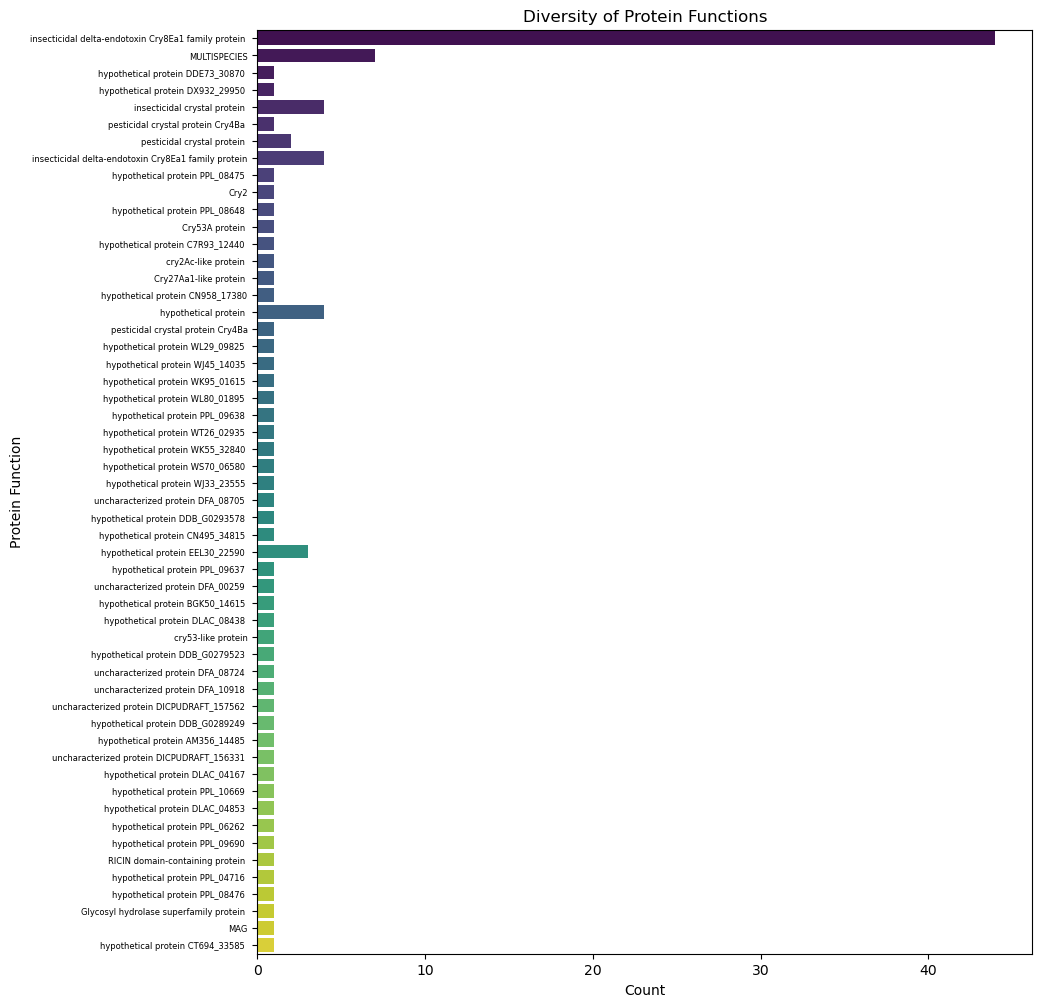

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# Group by qseqid and filter the data by top bit score per qseqid 
ncbi_pataa_filtered = ncbi_pataa_filtered.sort_values('bitscore', ascending=False).groupby('qseqid').head(1)


# Extract protein function
ncbi_pataa_filtered['Protein_Function'] = ncbi_pataa_filtered['ss.kingdoms'].str.extract(r'^([\w\s\-]+)[\[\:]*')

#Plot
plt.figure(figsize=(10, 12))

sns.countplot(y='Protein_Function', data=ncbi_pataa_filtered, palette='viridis')
plt.title("Diversity of Protein Functions")
plt.xlabel("Count")
plt.ylabel("Protein Function")

# Adjust font size on y-axis
plt.yticks(fontsize=6)


plt.show()

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_14341/2097550544.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


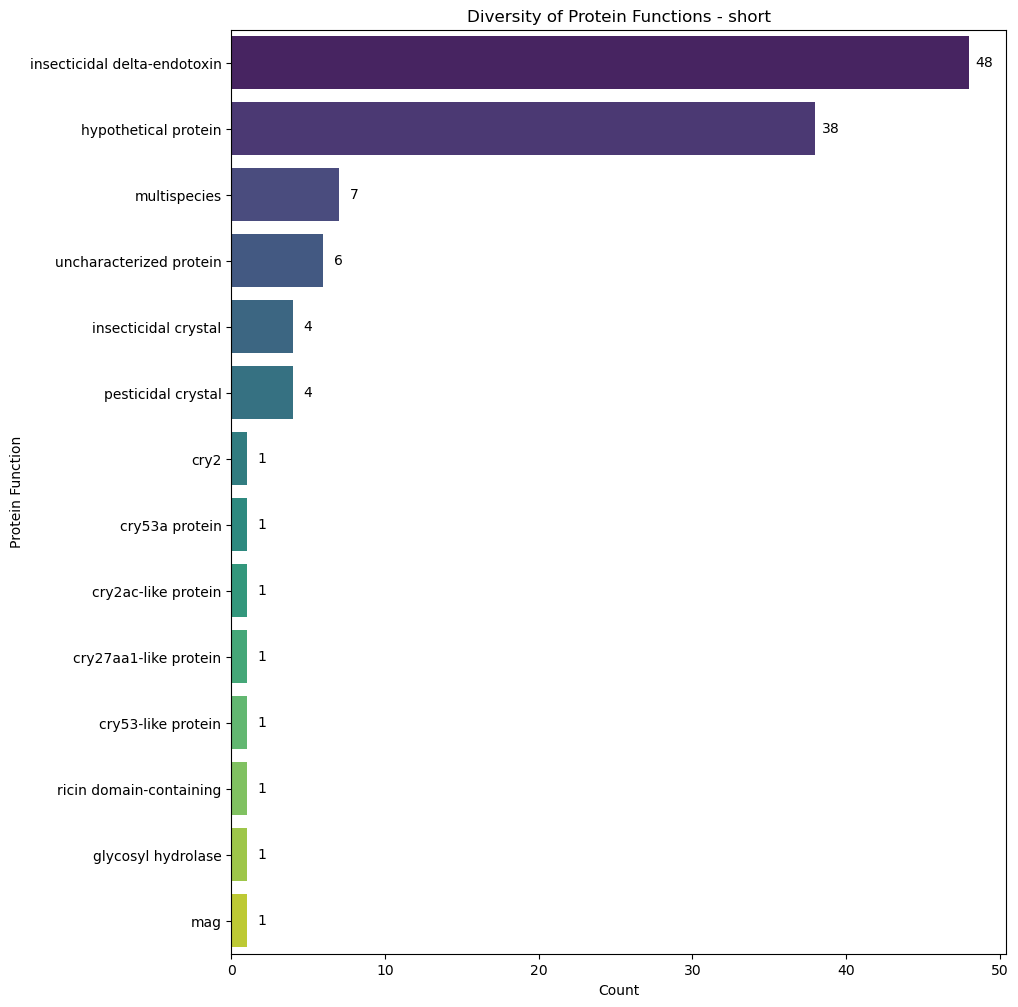

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Protein Function column to lowercase
ncbi_pataa_filtered['Protein_Function_lower'] = ncbi_pataa_filtered['Protein_Function'].str.lower()

# Split the protein function to only contain the first two words
ncbi_pataa_filtered['Protein_Function_short'] = (
    ncbi_pataa_filtered['Protein_Function_lower']
    .str.split()
    .str[:2]
    .str.join(' ')
)

# Sort by value counts
order = ncbi_pataa_filtered['Protein_Function_short'].value_counts().index

# Plot
plt.figure(figsize=(10, 12))
ax = sns.countplot(
    y='Protein_Function_short',
    data=ncbi_pataa_filtered,
    palette='viridis',
    order=order
)

# Add counts to the bars
for p in ax.patches:
    count = int(p.get_width())
    ax.text(p.get_width() + 1, p.get_y() + p.get_height() / 2, count, ha='center', va='center')

plt.title("Diversity of Protein Functions - short")
plt.xlabel("Count")
plt.ylabel("Protein Function")

# Adjust font size on y-axis
plt.yticks(fontsize=10)

plt.show()

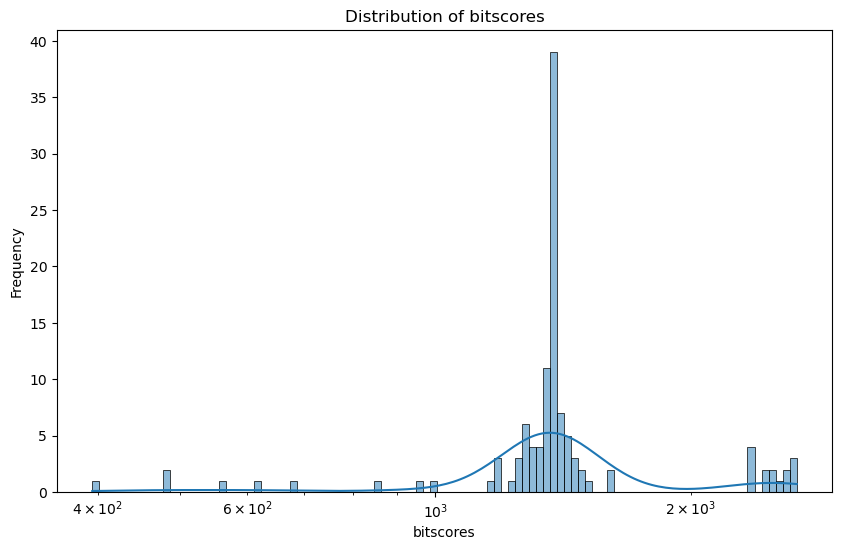

In [40]:
# make a histogram plot for the diversity of bitscores
plt.figure(figsize=(10, 6))
sns.histplot(ncbi_pataa_filtered['bitscore'], bins=100, kde=True, log_scale=(True, False))
plt.title("Distribution of bitscores")
plt.xlabel("bitscores")
plt.ylabel("Frequency")
#plt.xlim(0.75, 1.25)
plt.show()

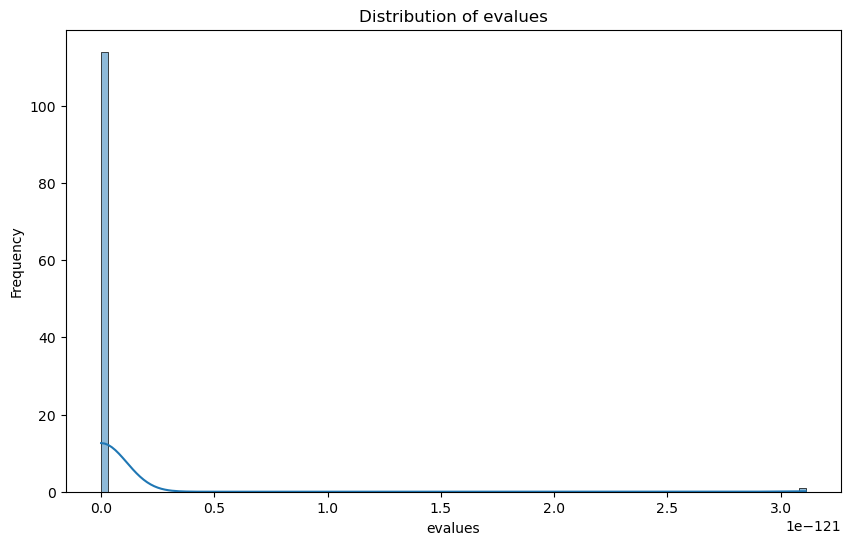

In [41]:
# make a histogram plot for the diversity of evalue
plt.figure(figsize=(10, 6))
sns.histplot(ncbi_pataa_filtered['evalue'], bins=100, kde=True) 
#log_scale=(True, False))
plt.title("Distribution of evalues")
plt.xlabel("evalues")
plt.ylabel("Frequency")
#plt.xlim(0.75, 1.25)
plt.show()

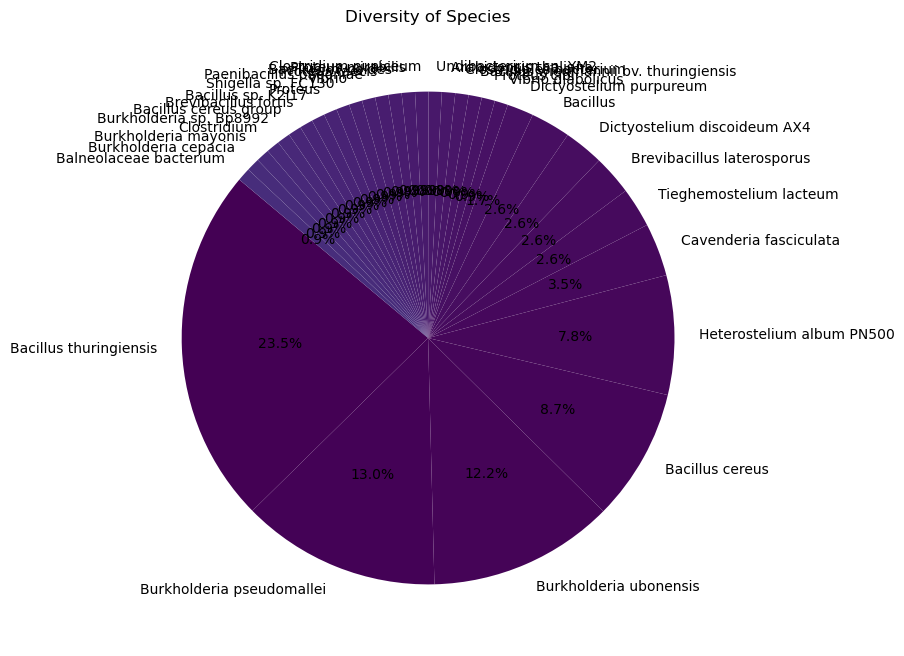

In [42]:
# Plot pie chart
ncbi_pataa_filtered['Species'] = ncbi_pataa_filtered['ss.kingdoms'].str.extract(r'\[(.*?)\]')
# Plot a bar chart

plt.figure(figsize=(8, 8))

species_counts = ncbi_pataa_filtered['Species'].value_counts()

plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.viridis.colors)
plt.title("Diversity of Species")
plt.show()

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_14341/866337881.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(species_counts))


<Figure size 1000x1000 with 0 Axes>

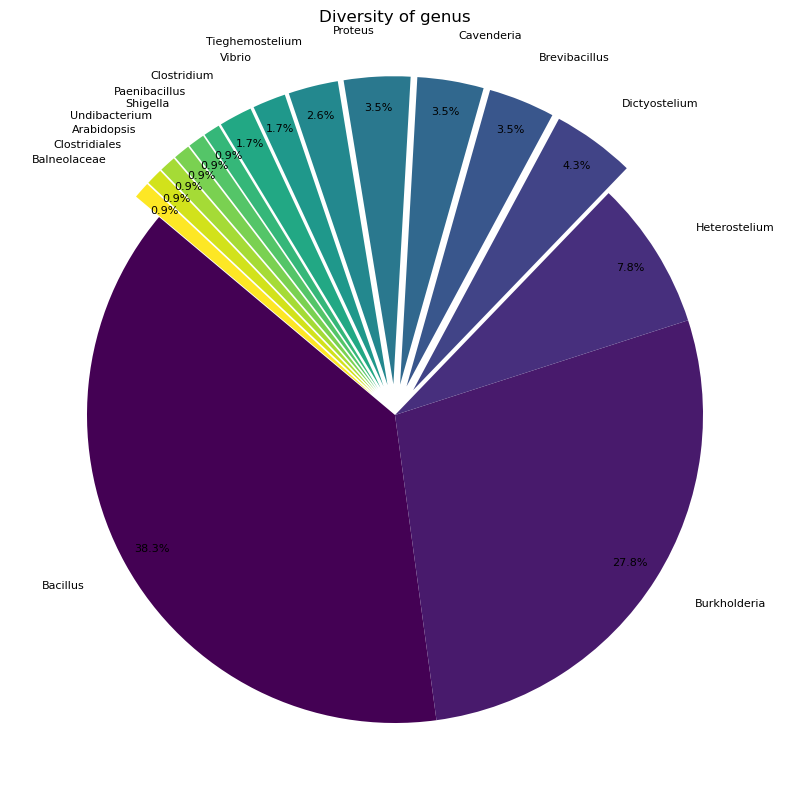

In [43]:
# Create 'genus' column by taking the first word from 'Species'
ncbi_pataa_filtered['genus'] = ncbi_pataa_filtered['Species'].str.split().str[0]

plt.figure(figsize=(10, 10))

species_counts = ncbi_pataa_filtered['genus'].value_counts()

# Get a colormap with enough colors
cmap = plt.cm.get_cmap('viridis', len(species_counts))

# Generate colors from the colormap
colors = cmap(range(len(species_counts)))

# Create an explode array to separate the slices slightly
explode = [0.1 if count < 0.05 * species_counts.sum() else 0 for count in species_counts]

plt.figure(figsize=(10, 10))
plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 8}, 
        labeldistance=1.15, pctdistance=0.9, explode=explode)

plt.title("Diversity of genus")
plt.show()

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_14341/874272739.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


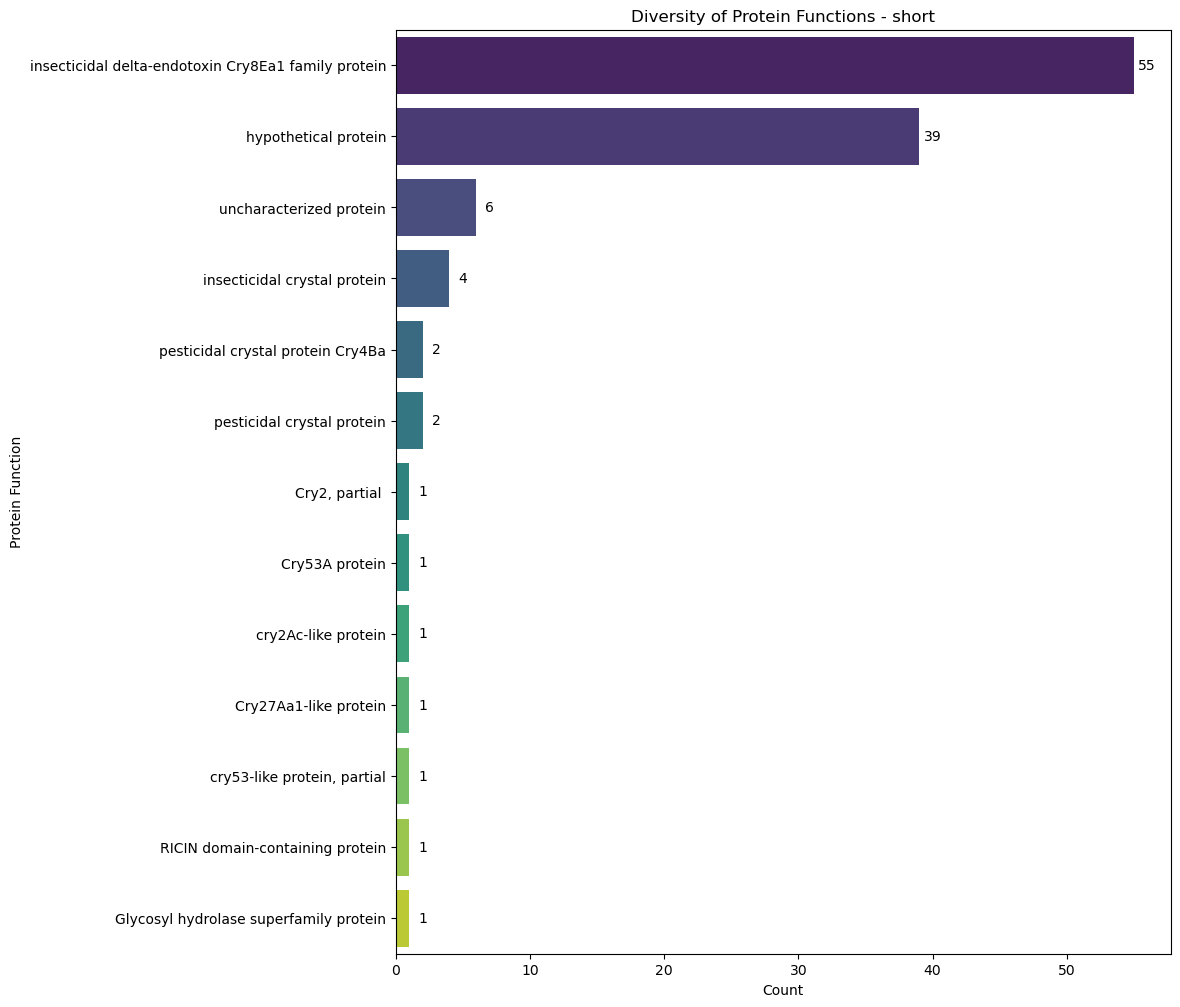

In [44]:
final_protein_function = pd.read_csv('/Volumes/behavgenom$-1/John/data_exp_info/BT/FoldSeek/commercial_proteins/5_final_check/final_protein_function.csv')

# Sort by value counts
order = final_protein_function['Protein'].value_counts().index

# Plot
plt.figure(figsize=(10, 12))
ax = sns.countplot(
    y='Protein',
    data=final_protein_function,
    palette='viridis',
    order=order
)

# Add counts to the bars
for p in ax.patches:
    count = int(p.get_width())
    ax.text(p.get_width() + 1, p.get_y() + p.get_height() / 2, count, ha='center', va='center')

plt.title("Diversity of Protein Functions - short")
plt.xlabel("Count")
plt.ylabel("Protein Function")

# Adjust font size on y-axis
plt.yticks(fontsize=10)

plt.show()

## Time to create a fasta file to prepare sequences to be ordered


In [46]:
# Make a fasta file of the final proteins with 'qseqid' as name and 'QuerySequence' as the amino acid sequence.
# One query needs to be manually adjusted is '4moa-assembly1.cif.gz_A' as the sequence does not start with "Methionine'. The original 4moa (Cry4Ba) has a length of 970 and aligns
# perfectly with our sequence, exscpet a truncation on the N-terminal and the C-terminal. On the N-terminal, it is missing 39 amino acids and as such needs to be supplemented with 
# these before codon optimisation.

# The sequence added to the N-terminal of 4moa-assembly1.cif.gz_A is from it's highest BLAST score (NCBI Reference Sequence: WP_236833314.1): 'MNSGYPLANDLQGSMKNTNYKDWLAMCENNQQYGVNPAA'

with open('/Volumes/behavgenom$-1/John/data_exp_info/BT/FoldSeek/commercial_proteins/5_final_check/final_proteins.fasta', 'w') as f:
    for index, row in unique_ncbi_pataa_filtered.iterrows():
        f.write(f">{row['qseqid']}\n{row['QuerySequence']}\n")